### Research Question: What are the key factors influencing real estate prices in the USA and how can they be used to accurately predict prices?

# Assessing & Handling Missing Data

In [1]:
import pandas as pd

df = pd.read_csv('realtor-data.csv')

df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0


Check for missing values

In [2]:
missing_values = df.isnull().sum()
print(missing_values / len(df)*100)

status             0.000000
bed               15.454518
bath              13.861802
acre_lot          25.513930
city               0.013632
state              0.000000
zip_code           0.034188
house_size        32.126395
prev_sold_date    48.983631
price              0.007708
dtype: float64


Given the size of the dataset(1.4 million entries) entries with missing data will be removed. Imputation of critical features such as bed, bath, and house size might introduce bias or inaccuracies. Data integrity is better preserved by removal. Previous sold date will be dropped entirely as it is not a feature of the house and not critical to analysis.

In [3]:
#number of entries before drop
old_num_entries = df.shape[0]
#drop prev sold date column
df = df.drop(['prev_sold_date'],axis=1)
#drop rows with any value missing
df = df.dropna()

new_num_entries = df.shape[0]


In [4]:
total_dropped = [old_num_entries-new_num_entries, new_num_entries/old_num_entries]

print(f"{total_dropped[0]} rows dropped. Leaving {total_dropped[1]*100:.2f}% of data.")

720602 rows dropped. Leaving 48.57% of data.


Appoximately half the data dropped but given the size of the dataset, there is still a substantial amount of data to ensure a robust analysis.

# Exploratory Data Analysis

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df.describe()


,bed,bath,acre_lot,zip_code,house_size,price
count,680464.000000,680464.000000,680464.000000,680464.000000,6.804640e+05,6.804640e+05
mean,3.788956,2.668498,35.394786,8228.550107,2.396661e+03,7.417357e+05
std,2.045182,2.031717,1315.912278,4539.135940,3.849113e+03,1.545217e+06
min,1.000000,1.000000,0.000000,601.000000,1.220000e+02,1.000000e+00
25%,3.000000,2.000000,0.120000,3907.000000,1.352000e+03,2.499000e+05
50%,3.000000,2.000000,0.290000,8360.000000,1.894000e+03,4.290000e+05
75%,4.000000,3.000000,1.000000,12168.000000,2.718000e+03,7.490000e+05
max,99.000000,198.000000,100000.000000,95652.000000,1.450112e+06,1.690000e+08


The maximum for bed, bath, acre_lot, price, and house_size appear to be significantly above the other percentiles. A box plot can better show the distribution.

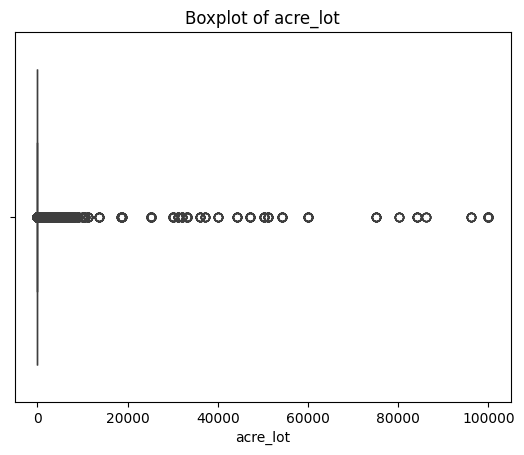

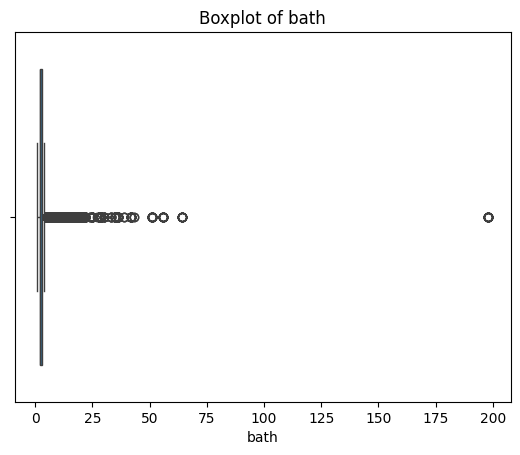

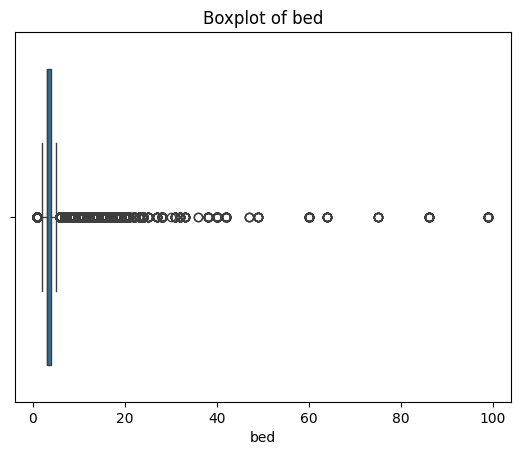

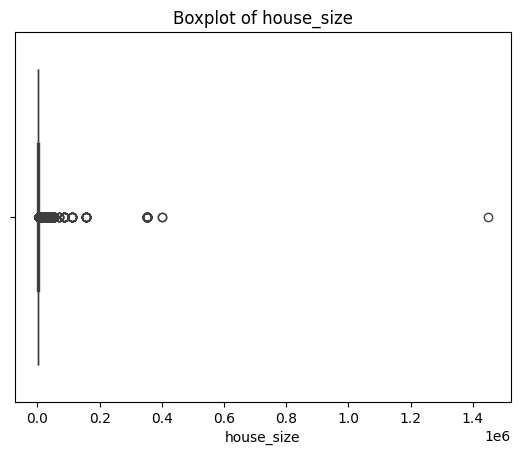

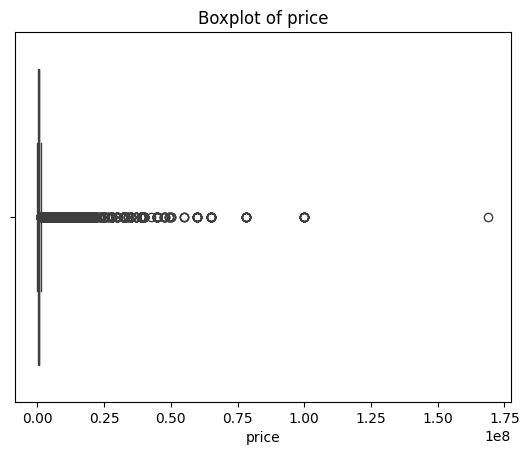

In [7]:
df_features = df[['acre_lot', 'bath', 'bed', 'house_size','price']]
for feature in df_features:
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()

Acre lot and bed have entries sporadically leading up to the maximum. House size and bath have large gaps between the data points. Let's use the Interquartile Range to detect outliers and remove outliers.

In [8]:
Q1 = df_features.quantile(0.25)
Q3 = df_features.quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers
outliers = (df_features < (Q1 - 1.5 * IQR)) | (df_features > (Q3 + 1.5 * IQR))

# Filtering out outliers
df_no_outliers = df[~(outliers).any(axis=1)]

In [9]:
print(df_no_outliers.describe())
print(f'\n{new_num_entries-df_no_outliers.shape[0]} rows removed.')

                 bed           bath       acre_lot       zip_code  \
count  469839.000000  469839.000000  469839.000000  469839.000000   
mean        3.295256       2.209823       0.438459    8366.660807   
std         0.825179       0.836804       0.488698    4626.332711   
min         2.000000       1.000000       0.000000     601.000000   
25%         3.000000       2.000000       0.120000    4101.000000   
50%         3.000000       2.000000       0.240000    8527.000000   
75%         4.000000       3.000000       0.540000   12198.000000   
max         5.000000       4.000000       2.320000   95652.000000   

          house_size         price  
count  469839.000000  4.698390e+05  
mean     1814.051279  4.403372e+05  
std       718.965681  2.849312e+05  
min       122.000000  1.000000e+00  
25%      1275.000000  2.290000e+05  
50%      1672.000000  3.700000e+05  
75%      2207.000000  5.990000e+05  
max      4767.000000  1.497000e+06  

210625 rows removed.


210,000 rows were removed with this method but ~470,000 entries remain and the maximums are closer to the rest of the data. 

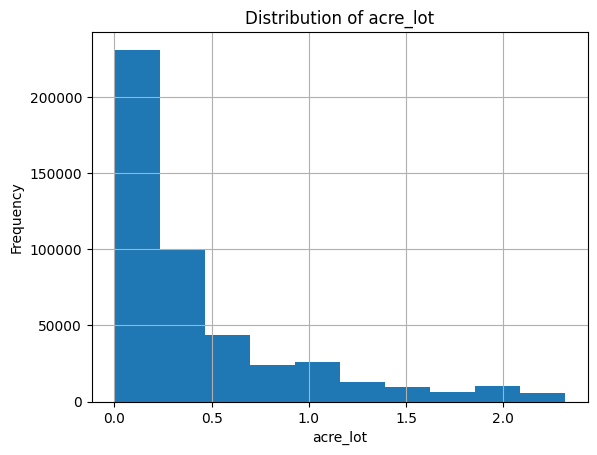

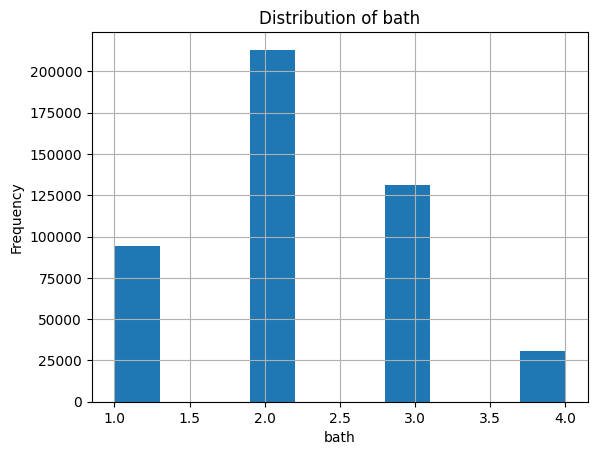

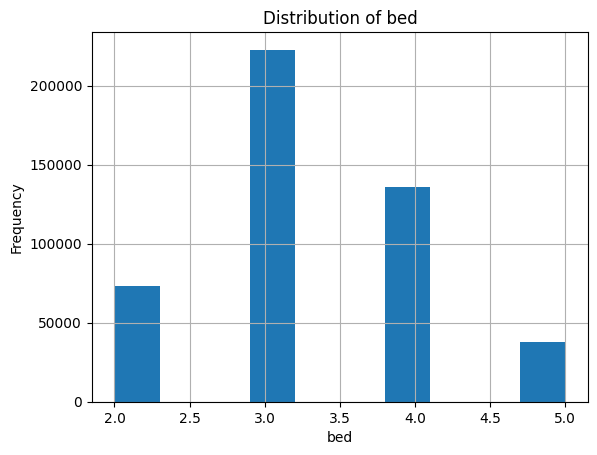

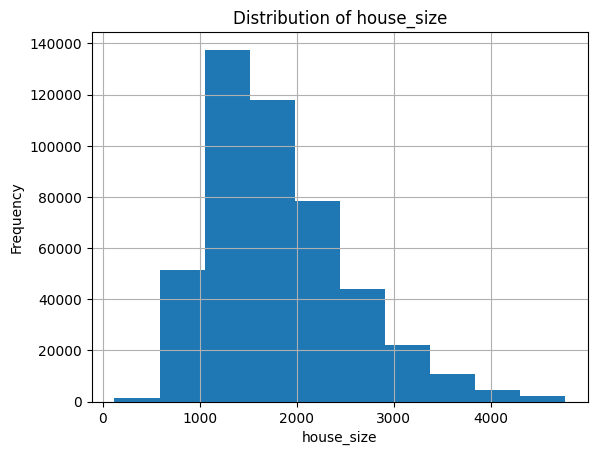

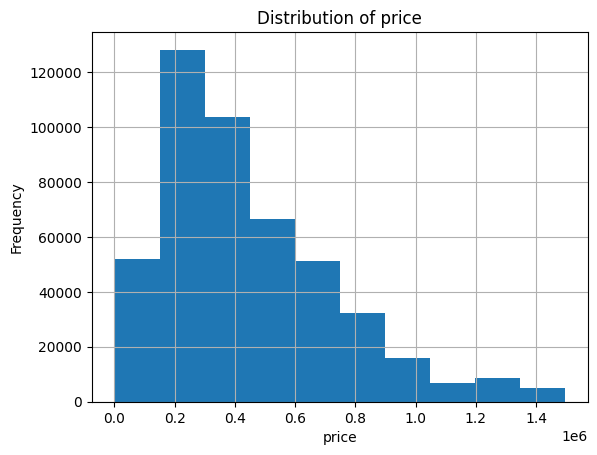

In [10]:
for feature in df_features:
    df_no_outliers[feature].hist()
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature}')
    plt.show()

Removing the outliers using the IQR shows more realistic feature values that we expect in a home. The outliers may have been luxury or commercial properties but given the extreme values they would have likely skewed the model's accuracy. I have a concern regarding the possible high cardinality of categorical features like zip_code.

In [11]:
df_no_outliers.info()
print(f"Number of unique zip codes: {len(df_no_outliers['zip_code'].unique())}")



<class 'pandas.core.frame.DataFrame'>
Index: 469839 entries, 0 to 1401065
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   status      469839 non-null  object 
 1   bed         469839 non-null  float64
 2   bath        469839 non-null  float64
 3   acre_lot    469839 non-null  float64
 4   city        469839 non-null  object 
 5   state       469839 non-null  object 
 6   zip_code    469839 non-null  float64
 7   house_size  469839 non-null  float64
 8   price       469839 non-null  float64
dtypes: float64(6), object(3)
memory usage: 35.8+ MB
Number of unique zip codes: 3612


Status is irrelevant in the data as they are all the same value. Given the unique number of zipcodes, encoding will significantly increase the dimensional space of the data. As an alternative, we will utilize models such as LightGBM that can handle categorical features without pre-processing.

In [12]:
df_no_outliers = df_no_outliers.drop(['status'],axis=1)

df = df_no_outliers


# Model Implementation

In [13]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#Set categorical features appropiately for model
categorical_features = ['state', 'city', 'zip_code']
df[categorical_features] = df[categorical_features].astype('category')

#Separate features and target
X = df.drop(['price'], axis=1)
y = df['price']

#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

#Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)

#Define model parameters
params =  {
    'objective': 'regression',
    'metric': 'mse',
    'boosting': 'gbdt',
    'verbose': -1
}

#Train the model
gbm = lgb.train(params, train_data, num_boost_round=100)

#Predict on test
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

#Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Test MSE: {mse}')
print(f'Test R2: {r2}')

Test MSE: 7944379503.702883
Test R2: 0.9019145472235667


The coefficient of determination(r2) shows the model fits the data well and 90.1% of the variation of price can be explained by the model's inputs. The Mean Squared Error(MSE) is quite large, this could be due to the large range of values. Let's look at the Root Mean Squared Error(RMSE) to convert it to the same units as the data. Additionally, we will look at the Mean Absolute Error(MAE) as a few very large errors could be skewing MSE. MAE is less sensitive to outliers than MSE.

In [14]:
import numpy as np

#Calculate residuals
residuals = y_test - y_pred

#Calculate RMSE
rmse = np.sqrt(mse)

#Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print(f'Test RMSE: {rmse}')
print(f'Test MAE: {mae}')

Test RMSE: 89131.24874982332
Test MAE: 60008.69449229439


On average the model appears to be within 60,000 to 89,000 within the predicted and actual price based on the MAE and RMSE respectively. To better understand the model's performance we will look at the residuals.

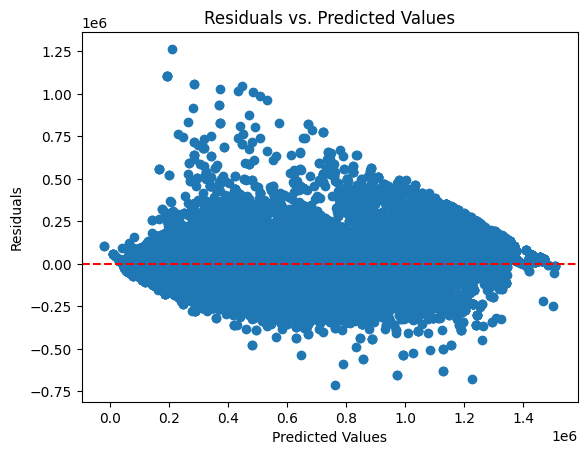

In [15]:
#Scatter plot of residuals
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

 The residuals are generally centered around the horizontal line at zero, indicating on average, the model's predictions are unbiased. The plot also exhibits a pattern where the variance of residuals increases as the predicted price increases; Which suggests the model's predictive accuracy varies across the range of predictions and is less precise for higher predicted values. This may be due to potential outliers or a lack of features to capture the full relationship.

 To further our understanding, we will look at the feature importance for the model.

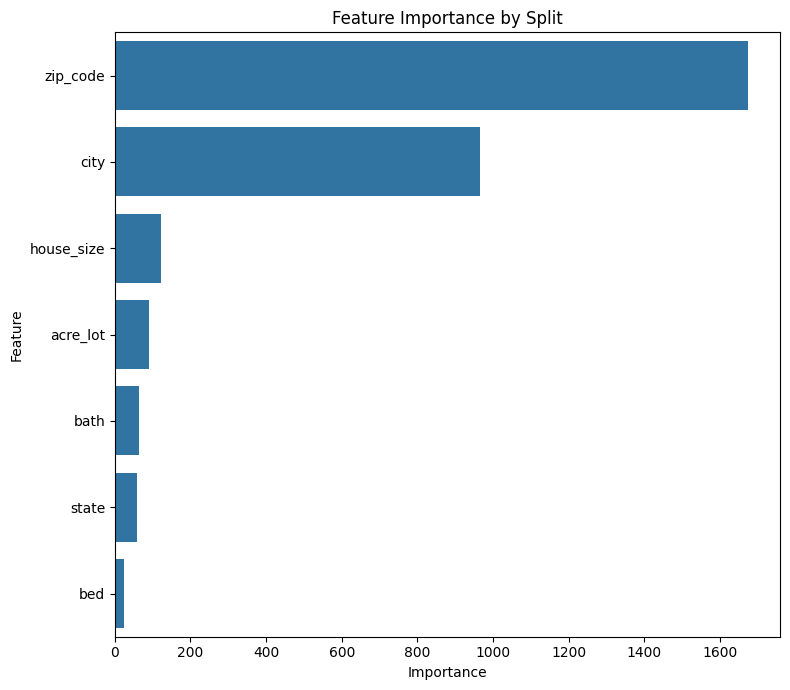

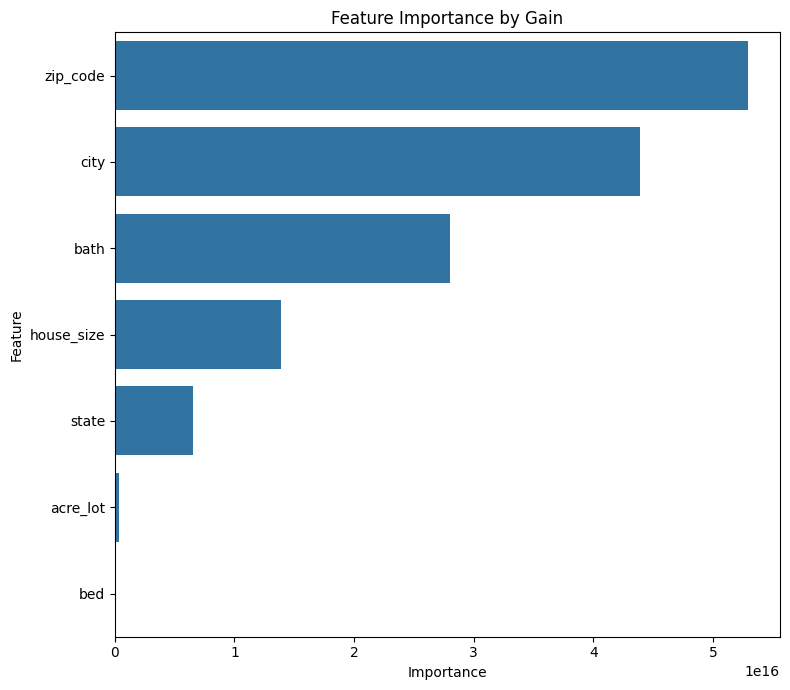

In [16]:
# Get feature importances
importance_split = gbm.feature_importance(importance_type='split')
importance_gain = gbm.feature_importance(importance_type='gain')

# Get feature names
feature_names = gbm.feature_name()

# Create a DataFrame for split importance
df_feature_importance_split = pd.DataFrame({
    'feature_name': feature_names,
    'importance': importance_split
}).sort_values('importance', ascending=False)

# Create a DataFrame for gain importance
df_feature_importance_gain = pd.DataFrame({
    'feature_name': feature_names,
    'importance': importance_gain
}).sort_values('importance', ascending=False)

# Plotting split importance
plt.figure(figsize=(8, 7))
sns.barplot(x='importance', y='feature_name', data=df_feature_importance_split.head(15))
plt.title('Feature Importance by Split')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Plotting gain importance
plt.figure(figsize=(8, 7))
sns.barplot(x='importance', y='feature_name', data=df_feature_importance_gain.head(15))
plt.title('Feature Importance by Gain')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

We can see by the results that zip code and city are the significant factors usage(split) and usefulness(gain) for the model. This could be nuanced information local to that area that is highly relevant to property prices. Given this is the driving factor in the model, we will ensure the model is not overfitting through cross-validation before tuning any parameters.

In [17]:
from sklearn.model_selection import KFold

#Initialize K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#Array for results
mse_scores = []
r2_scores = []
mae_scores = []
rmse_scores = []

#Start K-Fold cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    #Create LightGBM dataset for current fold
    train_data_fold = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)

    #Train model
    gbm_fold = lgb.train(params, train_data_fold, num_boost_round=100)

    #Predict on validation set
    y_pred_fold = gbm_fold.predict(X_val, num_iteration=gbm_fold.best_iteration)

    # Evaluate model
    mse_fold = mean_squared_error(y_val, y_pred_fold)
    mae_fold = mean_absolute_error(y_val, y_pred_fold)
    rmse_fold = np.sqrt(mse_fold)  # Calculate RMSE from MSE
    r2_fold = r2_score(y_val, y_pred_fold)

    # Store results
    mse_scores.append(mse_fold)
    mae_scores.append(mae_fold)
    rmse_scores.append(rmse_fold)
    r2_scores.append(r2_fold)

# Calculate average scores across all folds
average_mse = np.mean(mse_scores)
average_mae = np.mean(mae_scores)
average_rmse = np.mean(rmse_scores)
average_r2 = np.mean(r2_scores)

# Print the average scores
print(f'Average K-Fold Test MSE: {average_mse}')
print(f'Average K-Fold Test MAE: {average_mae}')
print(f'Average K-Fold Test RMSE: {average_rmse}')
print(f'Average K-Fold Test R2: {average_r2}')

Average K-Fold Test MSE: 8057427246.596751
Average K-Fold Test MAE: 60036.49665372745
Average K-Fold Test RMSE: 89762.1629122011
Average K-Fold Test R2: 0.9007510770205442


The results from cross-validation are almost identical to our original model meaning our model is not overfit. In this case, let's tune the parameters of our model to improve it's performance.

In [41]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# Define the space of hyperparameters to search
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 5),
    'num_boost_round': hp.quniform('num_boost_round', 50, 1000, 10),
}

# Define the objective function
def objective(hyperparams):
    # Make sure parameters that need to be integers are integers
    hyperparams['num_boost_round'] = int(hyperparams['num_boost_round'])
    hyperparams['num_leaves'] = int(hyperparams['num_leaves'])

    # Train test split for validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_test, label=y_test)

    # Set up the parameters for LightGBM
    params = {
        'objective': 'regression',
        'metric': 'mse',
        'verbose': -1,
        **hyperparams
    }

    # List to store the evaluation results for each iteration
    evals_result = {}

    # Train the model with the given hyperparameters
    model = lgb.train(params,
                      dtrain,
                      num_boost_round=hyperparams['num_boost_round'],
                      valid_sets=[dval],
                      callbacks=[lgb.early_stopping(stopping_rounds=50),  # Use callback for early stopping
                                 lgb.record_evaluation(evals_result)])

    # Predict on validation set
    pred = model.predict(X_test, num_iteration=model.best_iteration)

    # Calculate the MSE
    mse = mean_squared_error(y_test, pred)

    # Return the loss and status
    return {'loss': mse, 'status': STATUS_OK}

# Run the hyperparameter search using the Tree of Parzen Estimators (TPE) algorithm
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=35,
            trials=trials)

print("The best hyperparameters are: ", "\n")
print(best)


Training until validation scores don't improve for 50 rounds
  0%|          | 0/35 [00:00<?, ?trial/s, best loss=?]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:       
[790]	valid_0's l2: 3.53854e+09
  3%|▎         | 1/35 [00:17<09:59, 17.62s/trial, best loss: 3538542354.950436]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 50 rounds                   
Did not meet early stopping. Best iteration is:                                
[950]	valid_0's l2: 1.47504e+09
Training until validation scores don't improve for 50 rounds                    
  6%|▌         | 2/35 [00:33<09:00, 16.38s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                 
[940]	valid_0's l2: 3.30393e+09
Training until validation scores don't improve for 50 rounds                    
  9%|▊         | 3/35 [01:03<12:06, 22.69s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                 
[760]	valid_0's l2: 6.3763e+09
Training until validation scores don't improve for 50 rounds                    
 11%|█▏        | 4/35 [01:18<10:06, 19.56s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                 
[820]	valid_0's l2: 3.55422e+09
Training until validation scores don't improve for 50 rounds                    
 14%|█▍        | 5/35 [01:36<09:31, 19.04s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                 
[850]	valid_0's l2: 4.1898e+09
Training until validation scores don't improve for 50 rounds                    
 17%|█▋        | 6/35 [01:50<08:24, 17.39s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                 
[660]	valid_0's l2: 3.81533e+09
Training until validation scores don't improve for 50 rounds                    
 20%|██        | 7/35 [02:03<07:25, 15.93s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                 
[650]	valid_0's l2: 2.68562e+09
Training until validation scores don't improve for 50 rounds                    
 23%|██▎       | 8/35 [02:11<05:58, 13.27s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                 
[320]	valid_0's l2: 4.33598e+09
Training until validation scores don't improve for 50 rounds                    
 26%|██▌       | 9/35 [02:14<04:25, 10.22s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                 
[720]	valid_0's l2: 4.69058e+09
Training until validation scores don't improve for 50 rounds                     
 29%|██▊       | 10/35 [02:22<03:58,  9.55s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[590]	valid_0's l2: 6.44032e+09
Training until validation scores don't improve for 50 rounds                     
 31%|███▏      | 11/35 [02:35<04:17, 10.71s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[60]	valid_0's l2: 2.70638e+10
Training until validation scores don't improve for 50 rounds                     
 34%|███▍      | 12/35 [02:37<02:59,  7.82s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[190]	valid_0's l2: 1.03159e+10
Training until validation scores don't improve for 50 rounds                     
 37%|███▋      | 13/35 [02:40<02:20,  6.41s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[300]	valid_0's l2: 3.87416e+09
Training until validation scores don't improve for 50 rounds                     
 40%|████      | 14/35 [02:43<01:51,  5.33s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[240]	valid_0's l2: 4.7133e+09
Training until validation scores don't improve for 50 rounds                     
 43%|████▎     | 15/35 [02:46<01:34,  4.72s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[610]	valid_0's l2: 3.59926e+09
Training until validation scores don't improve for 50 rounds                     
 46%|████▌     | 16/35 [02:52<01:39,  5.25s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[170]	valid_0's l2: 4.67074e+09
Training until validation scores don't improve for 50 rounds                     
 49%|████▊     | 17/35 [02:55<01:18,  4.37s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[370]	valid_0's l2: 4.43051e+09
Training until validation scores don't improve for 50 rounds                     
 51%|█████▏    | 18/35 [02:59<01:12,  4.25s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[360]	valid_0's l2: 4.7388e+09
Training until validation scores don't improve for 50 rounds                     
 54%|█████▍    | 19/35 [03:04<01:13,  4.61s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[600]	valid_0's l2: 4.38632e+09
Training until validation scores don't improve for 50 rounds                     
 57%|█████▋    | 20/35 [03:45<03:51, 15.41s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[470]	valid_0's l2: 3.59929e+09
Training until validation scores don't improve for 50 rounds                     
 60%|██████    | 21/35 [03:53<03:03, 13.12s/trial, best loss: 1475036043.8093877]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[990]	valid_0's l2: 1.06869e+09
Training until validation scores don't improve for 50 rounds                     
 63%|██████▎   | 22/35 [04:05<02:47, 12.91s/trial, best loss: 1068686477.6573311]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[990]	valid_0's l2: 1.16001e+09
Training until validation scores don't improve for 50 rounds                     
 66%|██████▌   | 23/35 [04:13<02:19, 11.58s/trial, best loss: 1068686477.6573311]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[970]	valid_0's l2: 2.60878e+09
Training until validation scores don't improve for 50 rounds                     
 69%|██████▊   | 24/35 [04:24<02:02, 11.15s/trial, best loss: 1068686477.6573311]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[890]	valid_0's l2: 2.64778e+09
Training until validation scores don't improve for 50 rounds                     
 71%|███████▏  | 25/35 [04:35<01:53, 11.35s/trial, best loss: 1068686477.6573311]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[490]	valid_0's l2: 3.13946e+09
Training until validation scores don't improve for 50 rounds                     
 74%|███████▍  | 26/35 [04:42<01:30, 10.07s/trial, best loss: 1068686477.6573311]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[980]	valid_0's l2: 1.85864e+09
Training until validation scores don't improve for 50 rounds                     
 77%|███████▋  | 27/35 [04:54<01:24, 10.51s/trial, best loss: 1068686477.6573311]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[880]	valid_0's l2: 1.14108e+09
Training until validation scores don't improve for 50 rounds                     
 80%|████████  | 28/35 [05:04<01:12, 10.31s/trial, best loss: 1068686477.6573311]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[750]	valid_0's l2: 1.13021e+09
Training until validation scores don't improve for 50 rounds                     
 83%|████████▎ | 29/35 [05:15<01:04, 10.70s/trial, best loss: 1068686477.6573311]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[750]	valid_0's l2: 2.50368e+09
Training until validation scores don't improve for 50 rounds                     
 86%|████████▌ | 30/35 [05:27<00:55, 11.03s/trial, best loss: 1068686477.6573311]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[800]	valid_0's l2: 1.44557e+09
Training until validation scores don't improve for 50 rounds                     
 89%|████████▊ | 31/35 [05:37<00:42, 10.68s/trial, best loss: 1068686477.6573311]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[910]	valid_0's l2: 2.51786e+09
Training until validation scores don't improve for 50 rounds                     
 91%|█████████▏| 32/35 [05:53<00:37, 12.33s/trial, best loss: 1068686477.6573311]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[700]	valid_0's l2: 1.35322e+09
Training until validation scores don't improve for 50 rounds                     
 94%|█████████▍| 33/35 [06:00<00:21, 10.67s/trial, best loss: 1068686477.6573311]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[540]	valid_0's l2: 2.21856e+09
Training until validation scores don't improve for 50 rounds                     
 97%|█████████▋| 34/35 [06:06<00:09,  9.36s/trial, best loss: 1068686477.6573311]

/home/kao/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Did not meet early stopping. Best iteration is:                                  
[810]	valid_0's l2: 1.644e+09
100%|██████████| 35/35 [06:14<00:00, 10.70s/trial, best loss: 1068686477.6573311]
The best hyperparameters are:  

{'learning_rate': 0.1980734319073354, 'num_boost_round': 990.0, 'num_leaves': 120.0}


The parameters found by Hyperopt are quite aggressive and may be overfitting the data. We will run the model with these parameters and use cross validation along with feature and bagging fractioning; These parameters randomly select a subset of features and data which makes the model more robust and less prone to overfit. Additionally, early stopping rounds will stop the training process if the model's performance does not improve. This also reduces overfitting and learning noise or specific patterns in the training set.

In [19]:
# Define model parameters
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting': 'gbdt',
    'num_leaves': 120,
    'learning_rate': 0.2,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Initialize K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Arrays for results
mse_scores = []
r2_scores = []
mae_scores = []
rmse_scores = []

# Start K-Fold cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Create LightGBM datasets for current fold
    train_data_fold = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
    val_data_fold = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features)

    # Train model with early stopping
    gbm_fold = lgb.train(
        params, 
        train_data_fold, 
        num_boost_round=1000, 
        valid_sets=[val_data_fold], 
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )

    # Predict on validation set
    y_pred_fold = gbm_fold.predict(X_val, num_iteration=gbm_fold.best_iteration)

    # Evaluate model
    mse_fold = mean_squared_error(y_val, y_pred_fold)
    mae_fold = mean_absolute_error(y_val, y_pred_fold)
    rmse_fold = np.sqrt(mse_fold)
    r2_fold = r2_score(y_val, y_pred_fold)

    # Store results
    mse_scores.append(mse_fold)
    mae_scores.append(mae_fold)
    rmse_scores.append(rmse_fold)
    r2_scores.append(r2_fold)

# Calculate average scores across all folds
average_mse = np.mean(mse_scores)
average_mae = np.mean(mae_scores)
average_rmse = np.mean(rmse_scores)
average_r2 = np.mean(r2_scores)

print(f'Average K-Fold Test MSE: {average_mse}')
print(f'Average K-Fold Test MAE: {average_mae}')
print(f'Average K-Fold Test RMSE: {average_rmse}')
print(f'Average K-Fold Test R2: {average_r2}')


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 1.03682e+09
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 1.15522e+09
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 1.09426e+09
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 1.09465e+09
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 1.09482e+09
Average K-Fold Test MSE: 1095151933.4755065
Average K-Fold Test MAE: 15033.377707839303
Average K-Fold Test RMSE: 33088.24410301319
Average K-Fold Test R2: 0.986510402478468


The model's performance with the new parameters is significantly stronger with an R2 of 98.6% and RMSE of 33,000. While unlikely due to the number of entries(~400,000) and features such as zip code with high cardinality(~3,000 unique values); It's possible that the model is too complex for the dataset and still overfit the data. As a final check, let's look at a simpler model such as linear regression to compare performance.

In [23]:
from sklearn.linear_model import LinearRegression

# Initialize K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Arrays for results
lr_mse_scores = []
lr_r2_scores = []
lr_mae_scores = []
lr_rmse_scores = []

# Start K-Fold cross-validation
for train_index, val_index in kf.split(X):
    # Splitting the data
    X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Frequency encoding within each fold
    for col in ['zip_code', 'state', 'city']:
        # Compute frequencies on training data
        freq_encoding = X_train[col].value_counts().to_dict()
        
        # Apply encoding to both training and validation data
        X_train[f'{col}_freq'] = X_train[col].map(freq_encoding)
        X_val[f'{col}_freq'] = X_val[col].map(freq_encoding)

    # Drop original categorical columns
    X_train = X_train.drop(['zip_code', 'state', 'city'], axis=1)
    X_val = X_val.drop(['zip_code', 'state', 'city'], axis=1)

    # Train Linear Regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Predict on validation set
    y_pred_lr = lr_model.predict(X_val)

    # Evaluate model
    lr_mse = mean_squared_error(y_val, y_pred_lr)
    lr_mae = mean_absolute_error(y_val, y_pred_lr)
    lr_rmse = np.sqrt(lr_mse)
    lr_r2 = r2_score(y_val, y_pred_lr)

    # Store results
    lr_mse_scores.append(lr_mse)
    lr_mae_scores.append(lr_mae)
    lr_rmse_scores.append(lr_rmse)
    lr_r2_scores.append(lr_r2)

# Calculate average scores across all folds
average_lr_mse = np.mean(lr_mse_scores)
average_lr_mae = np.mean(lr_mae_scores)
average_lr_rmse = np.mean(lr_rmse_scores)
average_lr_r2 = np.mean(lr_r2_scores)

print(f'Linear Regression - Average K-Fold Test MSE: {average_lr_mse}')
print(f'Linear Regression - Average K-Fold Test MAE: {average_lr_mae}')
print(f'Linear Regression - Average K-Fold Test RMSE: {average_lr_rmse}')
print(f'Linear Regression - Average K-Fold Test R2: {average_lr_r2}')


Linear Regression - Average K-Fold Test MSE: 56572545043.550354
Linear Regression - Average K-Fold Test MAE: 180410.35577250348
Linear Regression - Average K-Fold Test RMSE: 237848.72938582403
Linear Regression - Average K-Fold Test R2: 0.30316211108359176


To avoid data leakage, frequency encoding was done within each fold of cross-validation to ensure that information from the validation set was not leaked to the training set. We can see that the simpler model with Linear Regression performed significantly worse than LightGBM. This suggests the dataset contains complex non-linear relationships that LightGBM can handle more effectively than Linear Regression.

#### Findings:
- The LightGBM model successfully identified crucial factors influencing real estate prices.
- The model demonstrated high accuracy with the evaluated metrics.

#### Implications:
- The model can significantly improve property valuation for real estate companies.
- Investors and professionals can levarage the model to understand market trends and make data-driven investment choices.